In [ ]:
import sys

In [ ]:
if 'google.colab' in str(get_ipython()):

  # To run in Gogogle Colab
  # You have to create a folder IFT6759 in your google drive 
  # and put all content of the folder ift-6759-forecast-project 

  #@title Mount your Google Drive

  %matplotlib inline
  %load_ext autoreload
  %autoreload 2

  from google.colab import drive
  #drive.mount('/content/gdrive')
  drive.mount("/content/gdrive", force_remount=True)

  folder = "/content/gdrive/MyDrive/IFT6759" #@param {type:"string"}
  !ln -Ts $folder /content/IFT6759 2> /dev/null

  # Add the assignment folder to Python path
  if '/content/IFT6759' not in sys.path:
      sys.path.insert(0, '/content/IFT6759')

  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/functions')
  import utils
  import load_creator
  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/models')
  import SUNSET
  import convGRU
  #sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759')
  !pip install -r /content/gdrive/MyDrive/IFT6759/requirements.txt

else:

  import models.SUNSET as SUNSET
  import models.convGRU as convGRU
  import functions.utils as utils
  import functions.load_creator as load_creator
  !pip install -r requirements.txt 

Mounted at /content/gdrive


In [ ]:
import os
import random
import numpy as np
from numpy import genfromtxt
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import shutil
import warnings

In [ ]:
# Create device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# set Random seed

seed = 10
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device.type=='cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#Load and split data in train & test sets and the 3 classes (sunny, cloudy and overcast) 

In [ ]:
# define folder location

dir_path = os.getcwd()

if 'google.colab' in str(get_ipython()):
  dir_path = os.path.join(dir_path, "gdrive/MyDrive/IFT6759")

data_folder = os.path.join(dir_path, "data")
model_folder = os.path.join(dir_path, "models")

#define file location

images_trainval_path = os.path.join(data_folder,'images_trainval.npy')
pv_log_trainval_path = os.path.join(data_folder,'pv_log_trainval.npy')
datetime_trainval_path = os.path.join(data_folder,'datetime_trainval.npy')

images_test_path = os.path.join(data_folder,'images_test.npy')
pv_log_test_path = os.path.join(data_folder,'pv_log_test.npy')
datetime_test_path = os.path.join(data_folder,'datetime_test.npy')

In [ ]:
# load PV output and images for the trainval set

pv_log_trainval = np.load(pv_log_trainval_path)
images_trainval = np.load(images_trainval_path)
images_trainval = np.transpose(images_trainval, (0,3,1,2))
datetimes_trainval = np.load(datetime_trainval_path, allow_pickle=True)

# load PV output and images for the test set

pv_log_test = np.load(pv_log_test_path)
images_test = np.load(images_test_path)
images_test = np.transpose(images_test, (0,3,1,2))
datetimes_test = np.load(datetime_test_path, allow_pickle=True)# get weather classification

# train
w_class_train_path = os.path.join(data_folder,'train_label_3_classes_d.csv')
w_class_train = pd.read_csv(w_class_train_path)

index_train_sunny = np.where(w_class_train == 'Sunny')[0].tolist()
index_train_cloudy = np.where(w_class_train == 'Cloudy')[0].tolist()
index_train_overcast = np.where(w_class_train == 'Overcast')[0].tolist() 

#test
w_class_test_path = os.path.join(data_folder,'test_label_3_classes_d.csv')
w_class_test = pd.read_csv(w_class_test_path)

index_test_sunny = np.where(w_class_test == 'Sunny')[0].tolist()
index_test_cloudy = np.where(w_class_test == 'Cloudy')[0].tolist()
index_test_overcast = np.where(w_class_test == 'Overcast')[0].tolist()

In [ ]:
np.shape(index_test_sunny), np.shape(index_test_cloudy), np.shape(index_test_overcast)

((5926,), (2941,), (1043,))

In [ ]:
#Sunny

pv_log_trainval_sunny = pv_log_trainval[index_train_sunny] 
images_trainval_sunny = images_trainval[index_train_sunny]
datetimes_trainval_sunny = datetimes_trainval[index_train_sunny]

pv_log_test_sunny = pv_log_test[index_test_sunny]
images_test_sunny = images_test[index_test_sunny]
datetimes_test_sunny = datetimes_test[index_test_sunny]

# cloudy

pv_log_trainval_cloudy = pv_log_trainval[index_train_cloudy] 
images_trainval_cloudy = images_trainval[index_train_cloudy]
datetimes_trainval_cloudy = datetimes_trainval[index_train_cloudy]

pv_log_test_cloudy = pv_log_test[index_test_cloudy]
images_test_cloudy = images_test[index_test_cloudy]
datetimes_test_cloudy = datetimes_test[index_test_cloudy]

# overcast

pv_log_trainval_overcast = pv_log_trainval[index_train_overcast] 
images_trainval_overcast = images_trainval[index_train_overcast]
datetimes_trainval_overcast = datetimes_trainval[index_train_overcast]

pv_log_test_overcast = pv_log_test[index_test_overcast]
images_test_overcast = images_test[index_test_overcast]
datetimes_test_overcast = datetimes_test[index_test_overcast]

In [ ]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Set Initial Configurations

In [ ]:
epochs = 30

configs = {
  1:  (1, epochs, 3e-6, 1e-5, 2, 0, 2, 'Baseline 2-0-2'),
  2:  (1, epochs, 3e-6, 1e-5, 2, 0, 0, 'Sunny - 2-0-0'),
  3:  (1, epochs, 3e-6, 1e-5, 1, 1, 2, 'Overcast - 2-0-1'),
  4:  (2, epochs, 1e-5, 1e-5, 0, 2, 2, 'Seq 2 - 0-2-2'),
  5:  (3, epochs, 1e-5, 1e-5, 2, 1, 2, 'Seq 3 - 2-1-2'),  
  6:  (2, epochs, 1e-5, 1e-5, 0, 2, 0, 'Seq 2 - 0-2-0'),
  7:  (2, epochs, 1e-5, 1e-5, 0, 2, 1, 'Seq 2 - 0-2-1'),
  8:  (3, epochs, 1e-5, 1e-5, 0, 2, 0, 'Seq 3 - 0-2-0'),
  9:  (3, epochs, 1e-5, 1e-5, 0, 2, 2, 'Seq 3 - 0-2-2'),
  10:  (3, epochs, 1e-5, 1e-5, 0, 2, 1, 'Seq 3 - 0-2-1'),
  11: (2, epochs, 1e-5, 1e-5, 0, 3, 2, 'Seq 2 - 0-3-2')
  }


# All data - ConvGRU

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[4]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval, datetimes_test, images_trainval, images_test, 
                                                         pv_log_trainval, pv_log_test, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 6.217737448204294 valid loss: 3.301277614472515 test loss: 3.810265932128868
epoch: 1 train loss: 3.217136290227682 valid loss: 2.635552773137079 test loss: 3.026596374564674
epoch: 2 train loss: 2.837339788447406 valid loss: 2.4093853172115582 test loss: 2.7497526766200626
epoch: 3 train loss: 2.634240004364168 valid loss: 2.256783455308852 test loss: 2.5558770690316677
epoch: 4 train loss: 2.500355169993009 valid loss: 2.2253801700298332 test loss: 2.5337344755949744
epoch: 5 train loss: 2.4059726152761205 valid loss: 2.1401780952730998 test loss: 2.4844481350164993
epoch: 6 train loss: 2.3515795873488092 valid loss: 2.0374829991900114 test loss: 2.399937111229563
epoch: 7 train loss: 2.2935312020012857 valid loss: 2.0177367312659875 test loss: 2.402391955224947
epoch: 8 train loss: 2.2387547552656777 valid loss: 1.9792404999551119 test loss: 2.348852377100266
epoch: 9 train loss: 2.2088560354872238 valid loss: 1.94607809202262 test loss: 2.332137194259546
epoch:

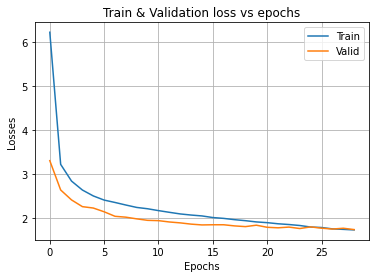

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Sunny - ConvGRU

## Return all layers = yes / convGRU_layers = 3 / fc_layers = 0

In [ ]:
seq_len = 2
num_epochs = 30
learning_rate = 1e-5
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU3(conv_layers=0, convGRU_layers = 3, fc_layers = 0 ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 6.960020337491713 valid loss: 3.9682888564732512 test loss: 4.052992045279546
epoch: 1 train loss: 2.9477232048685815 valid loss: 2.4140002500658233 test loss: 2.4185232442436493
epoch: 2 train loss: 2.2131870718585547 valid loss: 1.9991228070436793 test loss: 2.021902514228064
epoch: 3 train loss: 1.879945805728941 valid loss: 1.7466979613817237 test loss: 1.7712187359487745
epoch: 4 train loss: 1.6882282795072625 valid loss: 1.6014906600233358 test loss: 1.677727095821593
epoch: 5 train loss: 1.5597915213483105 valid loss: 1.484112572086432 test loss: 1.547553636715167
epoch: 6 train loss: 1.4621166692160754 valid loss: 1.4009708853380471 test loss: 1.4836903782439217
epoch: 7 train loss: 1.3947683048753126 valid loss: 1.352083288392376 test loss: 1.4519661472872034
epoch: 8 train loss: 1.3501712599691458 valid loss: 1.3147126573564605 test loss: 1.415289041295579
epoch: 9 train loss: 1.3120733061232492 valid loss: 1.2858379183040431 test loss: 1.392925966689101


## Return all layers = yes / convGRU_layers = 3 / fc_layers = 1

In [ ]:
seq_len = 2
num_epochs = 30
learning_rate = 1e-5
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU3(conv_layers=0, convGRU_layers = 3, fc_layers = 1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 3.948192947396879 valid loss: 1.9893601973364345 test loss: 2.0732688720798786
epoch: 1 train loss: 1.9097433055574324 valid loss: 1.5985615955901928 test loss: 1.6537010107349739
epoch: 2 train loss: 1.6672185736709693 valid loss: 1.439843237967535 test loss: 1.598009277732893
epoch: 3 train loss: 1.5621331770922442 valid loss: 1.3455331725577269 test loss: 1.4937253781604616
epoch: 4 train loss: 1.5042972261352556 valid loss: 1.2910732172871393 test loss: 1.4100850532120466
epoch: 5 train loss: 1.4347394428593443 valid loss: 1.2507758367913138 test loss: 1.401559154622434
epoch: 6 train loss: 1.4123771871062238 valid loss: 1.2420266229054018 test loss: 1.3686361901620836
epoch: 7 train loss: 1.3901207441890449 valid loss: 1.207324207040003 test loss: 1.3713899766184097
epoch: 8 train loss: 1.365020478607408 valid loss: 1.190334519643558 test loss: 1.3347516663435706
epoch: 9 train loss: 1.347300736651401 valid loss: 1.2278270817796646 test loss: 1.439970454094041

## Return all layers = yes / convGRU_layers = 3 / fc_layers = 2

In [ ]:
seq_len = 2
num_epochs = 30
learning_rate = 1e-5
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU3(conv_layers=0, convGRU_layers = 3, fc_layers = 2 ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 5.398310302266088 valid loss: 2.491404603664413 test loss: 2.47444857126022
epoch: 1 train loss: 2.5980800344761152 valid loss: 1.6634867942021203 test loss: 1.664277254018932
epoch: 2 train loss: 2.2132277657429986 valid loss: 1.4567022423015592 test loss: 1.5137654020175666
epoch: 3 train loss: 2.0526765959855586 valid loss: 1.4695154074238437 test loss: 1.5019474372065331
epoch: 4 train loss: 1.9487925270519266 valid loss: 1.3924919257857282 test loss: 1.4560074390780404
epoch: 5 train loss: 1.8858826239294366 valid loss: 1.4325448926710476 test loss: 1.5094810831711862
epoch: 6 train loss: 1.8415722135931392 valid loss: 1.2232429882533353 test loss: 1.388241921762527
epoch: 7 train loss: 1.8018445125275653 valid loss: 1.1999849817145616 test loss: 1.3608620415321413
epoch: 8 train loss: 1.7550391603254965 valid loss: 1.2102428973436423 test loss: 1.3622887153244523
epoch: 9 train loss: 1.7254689784015687 valid loss: 1.2396513942161713 test loss: 1.3827474091985

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 2

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[4]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))



epoch: 0 train loss: 7.162054391763511 valid loss: 3.5327797292216 test loss: 3.6886329298313596
epoch: 1 train loss: 3.0535116572108723 valid loss: 2.2274820411444187 test loss: 2.2610667731293375
epoch: 2 train loss: 2.3842268883537843 valid loss: 1.8097933892225178 test loss: 1.7787792920771408
epoch: 3 train loss: 2.137057931869082 valid loss: 1.6172069828548288 test loss: 1.6303156731160722
epoch: 4 train loss: 1.9969177580517408 valid loss: 1.5113491121968696 test loss: 1.5246924562883104
epoch: 5 train loss: 1.9108326192417282 valid loss: 1.4490043267742998 test loss: 1.4617775523173702
epoch: 6 train loss: 1.8217955093318696 valid loss: 1.4193709876218397 test loss: 1.4420674124545636
epoch: 7 train loss: 1.7755825049592806 valid loss: 1.3429995061929982 test loss: 1.381927918201813
epoch: 8 train loss: 1.7295148632049193 valid loss: 1.3283534544506455 test loss: 1.3771286695520784
epoch: 9 train loss: 1.6935140391306842 valid loss: 1.2781219346609032 test loss: 1.3786131454448

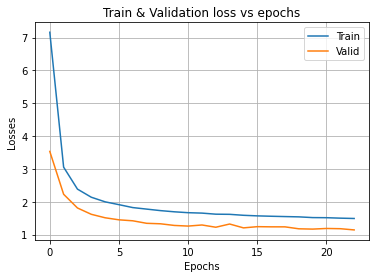

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / Conv = 2 / convGRU_layers = 1 / fc_layers = 2 (Seq lenght =3)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[5]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c5 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 10.31018670447419 valid loss: 4.101713528280083 test loss: 4.198164953121366
epoch: 1 train loss: 3.2850528999133477 valid loss: 2.7566375218899646 test loss: 2.7432455992915337
epoch: 2 train loss: 2.657668469044828 valid loss: 2.2670257726414396 test loss: 2.2864194785625926
epoch: 3 train loss: 2.2994454349450693 valid loss: 1.9227749219115287 test loss: 1.9318813968090676
epoch: 4 train loss: 2.0673425457854493 valid loss: 1.7069130677412818 test loss: 1.7275256005752293
epoch: 5 train loss: 1.9143302901214374 valid loss: 1.5586360875981724 test loss: 1.5850663392981885
epoch: 6 train loss: 1.8043986603454427 valid loss: 1.4584657914461314 test loss: 1.480019128665575
epoch: 7 train loss: 1.7397972925987988 valid loss: 1.3863593068401268 test loss: 1.4018753346544848
epoch: 8 train loss: 1.6922482463201234 valid loss: 1.3466386320501944 test loss: 1.3704918137181972
epoch: 9 train loss: 1.6484016740099345 valid loss: 1.3271361929903844 test loss: 1.340284820419

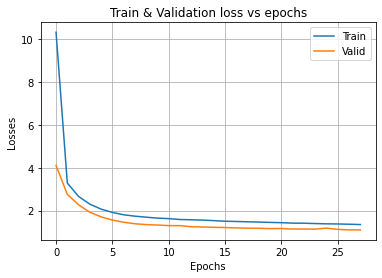

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 0

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[6]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c6 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 8.93787948340384 valid loss: 5.735890336177441 test loss: 5.742230018177463
epoch: 1 train loss: 5.289042907187393 valid loss: 4.632052641231096 test loss: 4.712300630818312
epoch: 2 train loss: 3.947963665380598 valid loss: 3.2405882292159505 test loss: 3.3395725752697367
epoch: 3 train loss: 2.9194270393879997 valid loss: 2.6721342377565542 test loss: 2.6706684731210784
epoch: 4 train loss: 2.5565369507265414 valid loss: 2.4504920360673883 test loss: 2.3845100284264364
epoch: 5 train loss: 2.3693675586028933 valid loss: 2.295555975521443 test loss: 2.220591533775337
epoch: 6 train loss: 2.2267556005835263 valid loss: 2.1661219302444734 test loss: 2.08713615496063
epoch: 7 train loss: 2.1027538162169015 valid loss: 2.0567277173504483 test loss: 1.960216478780984
epoch: 8 train loss: 1.996151156411148 valid loss: 1.9514350055899652 test loss: 1.8787451177136594
epoch: 9 train loss: 1.9000406683319675 valid loss: 1.863490703996525 test loss: 1.795663110202232
epoch:

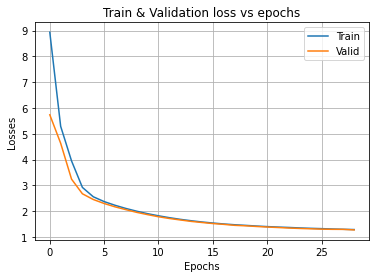

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 1

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[7]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c7 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 9.186557972984694 valid loss: 5.343100214334482 test loss: 5.360213185428533
epoch: 1 train loss: 4.57859485613395 valid loss: 3.1568568983015375 test loss: 3.17377025049458
epoch: 2 train loss: 2.95712370162414 valid loss: 2.4163958984022433 test loss: 2.3801227863417393
epoch: 3 train loss: 2.565673927728403 valid loss: 2.131588856404446 test loss: 2.1121739277063925
epoch: 4 train loss: 2.3446825387565817 valid loss: 1.9201463715238356 test loss: 1.9406534488215375
epoch: 5 train loss: 2.181469689104567 valid loss: 1.7677246093011383 test loss: 1.7755805626064747
epoch: 6 train loss: 2.0625279455262437 valid loss: 1.6554718749305464 test loss: 1.6680814347460085
epoch: 7 train loss: 1.966809584205069 valid loss: 1.5687668269356894 test loss: 1.5815454203471302
epoch: 8 train loss: 1.9029725279598413 valid loss: 1.523273723493138 test loss: 1.5276394168996417
epoch: 9 train loss: 1.8398173297887093 valid loss: 1.4389944881853234 test loss: 1.4848458047261508
epoc

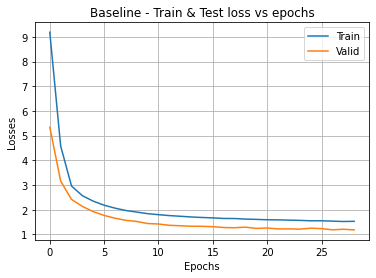

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 0 (Seq lenght =3)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[8]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 8.287052895925006 valid loss: 5.371589265917695 test loss: 5.388786916343876
epoch: 1 train loss: 4.896185186135051 valid loss: 4.310077562820841 test loss: 4.389148921612065
epoch: 2 train loss: 3.8467006175302965 valid loss: 3.305054406680732 test loss: 3.4030336837671404
epoch: 3 train loss: 3.0408795242987963 valid loss: 2.731033767470391 test loss: 2.774229374893548
epoch: 4 train loss: 2.6257781262047044 valid loss: 2.4437628660460016 test loss: 2.4386708098909993
epoch: 5 train loss: 2.3759862355239196 valid loss: 2.234058956990292 test loss: 2.2287577027275534
epoch: 6 train loss: 2.1789380138963725 valid loss: 2.055128137413205 test loss: 2.11585669546201
epoch: 7 train loss: 2.0140758773124956 valid loss: 1.9008250951625068 test loss: 1.9562751540394605
epoch: 8 train loss: 1.8785178630493853 valid loss: 1.7811509890360153 test loss: 1.86311857856875
epoch: 9 train loss: 1.7690952754770128 valid loss: 1.6846275939660915 test loss: 1.7865362857644191
epoch

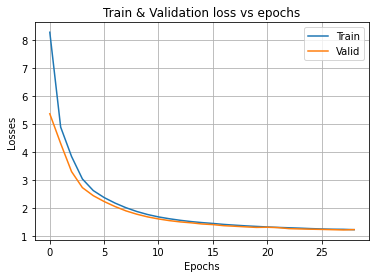

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 2 (Seq lenght =3)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[9]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 6.9173649601743294 valid loss: 3.349495988609216 test loss: 3.494870847340341
epoch: 1 train loss: 2.9545641581062623 valid loss: 2.137958140348977 test loss: 2.167136982610884
epoch: 2 train loss: 2.329882497014681 valid loss: 1.7424932994271516 test loss: 1.783364030630408
epoch: 3 train loss: 2.093094468993588 valid loss: 1.6033878148460432 test loss: 1.6113736139161323
epoch: 4 train loss: 1.9565399904785734 valid loss: 1.4767379111992018 test loss: 1.5640757907630298
epoch: 5 train loss: 1.8790375594987687 valid loss: 1.4078574496183025 test loss: 1.4616213413789996
epoch: 6 train loss: 1.8043068499799106 valid loss: 1.3476815093685053 test loss: 1.4384029667269616
epoch: 7 train loss: 1.7410721092785608 valid loss: 1.324844244640111 test loss: 1.44530657791592
epoch: 8 train loss: 1.7012840504072164 valid loss: 1.4098630614488885 test loss: 1.4605321073330941
epoch: 9 train loss: 1.6890977766245938 valid loss: 1.2791263083041355 test loss: 1.3792696024197444


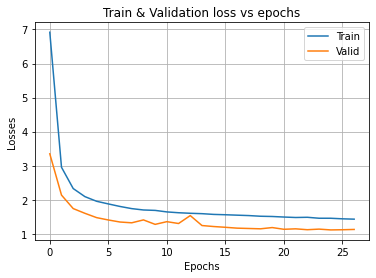

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 1 (Seq lenght =3)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[10]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 4.906888108669517 valid loss: 2.3272921923343706 test loss: 2.2862188699429105
epoch: 1 train loss: 2.2154445546575516 valid loss: 1.796541577531732 test loss: 1.828951583436517
epoch: 2 train loss: 1.9012098468395986 valid loss: 1.5720711706095307 test loss: 1.6665456096755202
epoch: 3 train loss: 1.7475621476542302 valid loss: 1.4513231193900256 test loss: 1.5394266438674395
epoch: 4 train loss: 1.6391728365135556 valid loss: 1.3731413103283232 test loss: 1.4698626968810626
epoch: 5 train loss: 1.5633082296090615 valid loss: 1.3292078099164975 test loss: 1.4399999237867753
epoch: 6 train loss: 1.5166439326810384 valid loss: 1.2615062462601863 test loss: 1.4077476247870635
epoch: 7 train loss: 1.4708745991092818 valid loss: 1.2471344615454685 test loss: 1.3832266022605035
epoch: 8 train loss: 1.444103937326794 valid loss: 1.2135245288331964 test loss: 1.3704914156986885
epoch: 9 train loss: 1.4202180109187923 valid loss: 1.1904240441683838 test loss: 1.35139591756

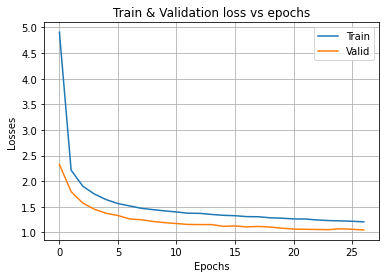

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 3 / fc_layers = 2

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[11]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 8.934158673335807 valid loss: 5.594827144424096 test loss: 5.548738608692092
epoch: 1 train loss: 4.764129830040379 valid loss: 3.240474631961835 test loss: 3.2974367564690468
epoch: 2 train loss: 3.011147900700521 valid loss: 2.3797045479739816 test loss: 2.3328191301446424
epoch: 3 train loss: 2.5179959397035203 valid loss: 2.0069795817057905 test loss: 1.9616037481634205
epoch: 4 train loss: 2.279472726974565 valid loss: 1.798165743441965 test loss: 1.8021581424861097
epoch: 5 train loss: 2.1127544309899116 valid loss: 1.6669432427091404 test loss: 1.6968775973250934
epoch: 6 train loss: 2.0166199284799924 valid loss: 1.5497445752333459 test loss: 1.5616529302648214
epoch: 7 train loss: 1.94539337452751 valid loss: 1.4975537370188545 test loss: 1.549271209992599
epoch: 8 train loss: 1.879737023441765 valid loss: 1.4370240049706817 test loss: 1.4714839019927521
epoch: 9 train loss: 1.8344996092235855 valid loss: 1.395144142147168 test loss: 1.462186618764788
epoc

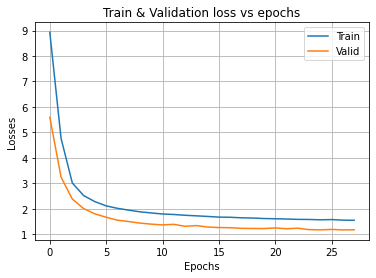

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Cloudy - ConvGRU

## Return all layers = yes / convGRU_layers = 3 / fc_layers = 1

In [ ]:
seq_len = 2
num_epochs = 80
learning_rate = 5e-6
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU3(conv_layers=0, convGRU_layers = 3, fc_layers = 1).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 2 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 6.7428681070336225 valid loss: 5.103568269839877 test loss: 6.049986243249958
epoch: 1 train loss: 4.68224086858551 valid loss: 4.388687250086837 test loss: 5.346539439550333
epoch: 2 train loss: 4.187619729355262 valid loss: 4.016703479018313 test loss: 4.8778396323674
epoch: 3 train loss: 3.9134791386234684 valid loss: 3.812643576792792 test loss: 4.64310405208291
epoch: 4 train loss: 3.706381706437263 valid loss: 3.6205083467866563 test loss: 4.3396024010905645
epoch: 5 train loss: 3.5413176136009343 valid loss: 3.486821483618491 test loss: 4.171174320416046
epoch: 6 train loss: 3.411196208292423 valid loss: 3.3977974389558576 test loss: 4.060899533768355
epoch: 7 train loss: 3.3193296736416182 valid loss: 3.3788609346623137 test loss: 4.053276689631197
epoch: 8 train loss: 3.2379929447904265 valid loss: 3.258819573852171 test loss: 3.9289795475475833
epoch: 9 train loss: 3.174450622900486 valid loss: 3.21333928549952 test loss: 3.8768497654246596
epoch: 10 trai

## Return all layers = yes / convGRU_layers = 3 / fc_layers = 0

In [ ]:
seq_len = 2
num_epochs = 80
learning_rate = 5e-6
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU3(conv_layers=0, convGRU_layers = 3, fc_layers = 0).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 2 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 8.83664272624135 valid loss: 6.872663223177743 test loss: 7.396860378541578
epoch: 1 train loss: 6.597349303814988 valid loss: 6.258466197852348 test loss: 7.053909647498462
epoch: 2 train loss: 5.997398867641228 valid loss: 5.680648276842015 test loss: 6.690238509406699
epoch: 3 train loss: 5.479379658193883 valid loss: 5.222617657511112 test loss: 6.320116283098794
epoch: 4 train loss: 5.080654044578203 valid loss: 4.872584516943135 test loss: 6.008924243825903
epoch: 5 train loss: 4.791579701674129 valid loss: 4.625823911462375 test loss: 5.747878180431466
epoch: 6 train loss: 4.57601790793981 valid loss: 4.437449572243041 test loss: 5.485129019279586
epoch: 7 train loss: 4.397970596713351 valid loss: 4.2819513476096995 test loss: 5.327776753893377
epoch: 8 train loss: 4.255461086408301 valid loss: 4.158904364726064 test loss: 5.114404737617655
epoch: 9 train loss: 4.13936401657936 valid loss: 4.052711377580953 test loss: 4.984207521347007
epoch: 10 train loss: 

## Return all layers = yes / convGRU_layers = 3 / fc_layers = 2

In [ ]:
seq_len = 2
num_epochs = 80
learning_rate = 5e-6
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU3(conv_layers=0, convGRU_layers = 3, fc_layers = 2).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 2 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 7.9980116528900425 valid loss: 6.206872111595144 test loss: 6.918310341655881
epoch: 1 train loss: 5.784127529221863 valid loss: 4.940904249255257 test loss: 5.95965733181427
epoch: 2 train loss: 4.874182212594998 valid loss: 4.339867824919349 test loss: 5.199910319521144
epoch: 3 train loss: 4.437720852571526 valid loss: 3.929578559922253 test loss: 4.806898512220755
epoch: 4 train loss: 4.140048478206707 valid loss: 3.737875105403877 test loss: 4.38871266993986
epoch: 5 train loss: 3.928239260974096 valid loss: 3.5779645470813737 test loss: 4.176747229544815
epoch: 6 train loss: 3.781365018261743 valid loss: 3.447688418777791 test loss: 4.0361894490284
epoch: 7 train loss: 3.668408196049423 valid loss: 3.31982075268278 test loss: 3.962790427968072
epoch: 8 train loss: 3.5602503100153613 valid loss: 3.270011476957713 test loss: 3.857200752961154
epoch: 9 train loss: 3.5006527497663074 valid loss: 3.271490569082293 test loss: 3.835168550929711
epoch: 10 train loss:

## Return all layers = no / convGRU_layers = 2 / fc_layers = 2

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[4]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 8.740792379325137 valid loss: 6.61511922498495 test loss: 7.178934529635244
epoch: 1 train loss: 6.132892952400634 valid loss: 5.266228312876442 test loss: 6.252248615573324
epoch: 2 train loss: 4.982140229600949 valid loss: 4.414113668116492 test loss: 5.371563949335745
epoch: 3 train loss: 4.391738305446092 valid loss: 3.9501343036558314 test loss: 4.875983679480371
epoch: 4 train loss: 4.045971272658999 valid loss: 3.7050186850507365 test loss: 4.465614284786458
epoch: 5 train loss: 3.8377062753416675 valid loss: 3.5306873062806896 test loss: 4.251488793258108
epoch: 6 train loss: 3.6702725534740233 valid loss: 3.3902883664755903 test loss: 4.091133331470567
epoch: 7 train loss: 3.554336369314264 valid loss: 3.32161137980607 test loss: 3.9350228348410465
epoch: 8 train loss: 3.466156498627634 valid loss: 3.232322873199406 test loss: 3.8806269677940826
epoch: 9 train loss: 3.379986961197427 valid loss: 3.2172744247245006 test loss: 3.7979905539451173
epoch: 10 tr

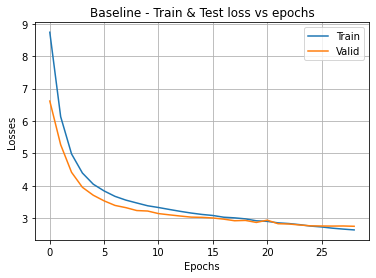

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / conv = 2 / convGRU_layers = 1 / fc_layers = 2 (Seq = 3)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[5]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c5 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 11.901181467566555 valid loss: 7.106224394386014 test loss: 7.836093098391562
epoch: 1 train loss: 6.451856893531573 valid loss: 5.688186400285426 test loss: 6.8889818822570685
epoch: 2 train loss: 5.311869944315861 valid loss: 4.81902064030666 test loss: 5.983276005057686
epoch: 3 train loss: 4.656852201460346 valid loss: 4.293399885927754 test loss: 5.27179526270409
epoch: 4 train loss: 4.230777441709727 valid loss: 3.919631078554226 test loss: 4.764314704948043
epoch: 5 train loss: 3.89562998244646 valid loss: 3.6202637944624136 test loss: 4.298539749405575
epoch: 6 train loss: 3.6347841695090093 valid loss: 3.4146273275850434 test loss: 3.9360371067065563
epoch: 7 train loss: 3.444327969770902 valid loss: 3.289734709416389 test loss: 3.7540749564948497
epoch: 8 train loss: 3.317880538471383 valid loss: 3.187866271203668 test loss: 3.736433402874747
epoch: 9 train loss: 3.22934321746745 valid loss: 3.1336994854100655 test loss: 3.6599593441263893
epoch: 10 train

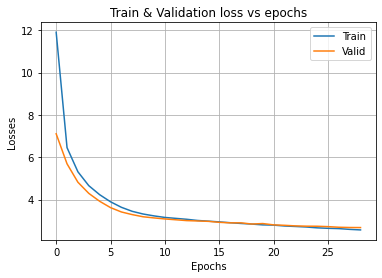

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 0

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[6]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c6 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 9.725625687754063 valid loss: 7.242064780514177 test loss: 7.491108775578108
epoch: 1 train loss: 6.956858403599148 valid loss: 6.828412970375299 test loss: 7.310622042165581
epoch: 2 train loss: 6.482392938988597 valid loss: 6.250735323197317 test loss: 7.020443533897134
epoch: 3 train loss: 5.896757454399202 valid loss: 5.662303985298618 test loss: 6.716484853747415
epoch: 4 train loss: 5.408470221838279 valid loss: 5.238952576752556 test loss: 6.391896377421656
epoch: 5 train loss: 5.079476044845034 valid loss: 4.947269713387425 test loss: 6.081840176741919
epoch: 6 train loss: 4.845931134120767 valid loss: 4.727696793341924 test loss: 5.776242601671916
epoch: 7 train loss: 4.654484415201887 valid loss: 4.541952410566256 test loss: 5.536364294652452
epoch: 8 train loss: 4.511928932335891 valid loss: 4.399780277095409 test loss: 5.3256718781218435
epoch: 9 train loss: 4.394032218283996 valid loss: 4.27677401040878 test loss: 5.18045841134641
epoch: 10 train loss:

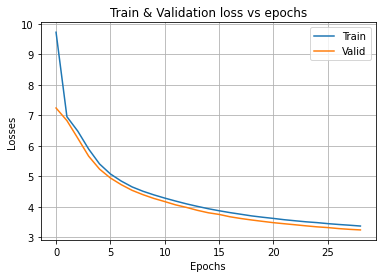

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 1

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[7]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c7 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 7.265977837848892 valid loss: 5.500904762819586 test loss: 6.422703383433527
epoch: 1 train loss: 4.986392856714747 valid loss: 4.529264452886262 test loss: 5.561964544529352
epoch: 2 train loss: 4.3716167679281295 valid loss: 4.104685828906429 test loss: 5.044581500142919
epoch: 3 train loss: 4.0178042457759355 valid loss: 3.8264846578919274 test loss: 4.58934266935129
epoch: 4 train loss: 3.774861612064543 valid loss: 3.6139739918335008 test loss: 4.325678547081538
epoch: 5 train loss: 3.6062043344704904 valid loss: 3.4684986196149796 test loss: 4.149612373078153
epoch: 6 train loss: 3.485477841207936 valid loss: 3.415560323645452 test loss: 4.033195106186131
epoch: 7 train loss: 3.4080851214708114 valid loss: 3.2898467279268524 test loss: 3.929284402498233
epoch: 8 train loss: 3.3162661206161905 valid loss: 3.2208167486258623 test loss: 3.8980080089244344
epoch: 9 train loss: 3.265837448176926 valid loss: 3.1813996791149455 test loss: 3.8454431944169567
epoch: 1

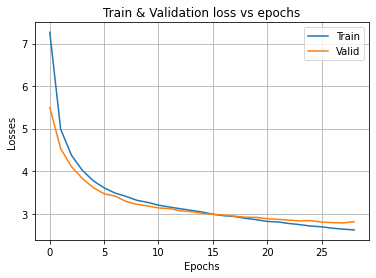

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 0 (Seq = 3)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[8]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 9.625808595937773 valid loss: 7.1206828771974005 test loss: 7.516624427656092
epoch: 1 train loss: 6.953609929412237 valid loss: 6.727013151399259 test loss: 7.289238658824502
epoch: 2 train loss: 6.517659097198348 valid loss: 6.253889086606019 test loss: 7.0327929955974975
epoch: 3 train loss: 6.0154451110033005 valid loss: 5.737176967031697 test loss: 6.660340275597537
epoch: 4 train loss: 5.526416980076504 valid loss: 5.275237270364454 test loss: 6.294677769898946
epoch: 5 train loss: 5.112740546124648 valid loss: 4.940249232157666 test loss: 6.003111024915705
epoch: 6 train loss: 4.809419785511802 valid loss: 4.6676087871460785 test loss: 5.657291704690718
epoch: 7 train loss: 4.579223626537821 valid loss: 4.447215748481184 test loss: 5.400396447430912
epoch: 8 train loss: 4.397647834011669 valid loss: 4.303846840031147 test loss: 5.228323042162348
epoch: 9 train loss: 4.274462629562671 valid loss: 4.202812493817301 test loss: 5.061032340234704
epoch: 10 train 

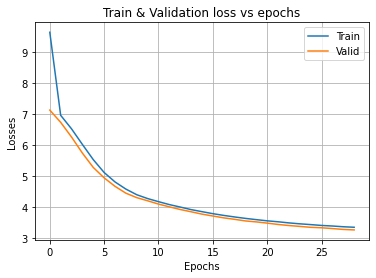

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 2 (Seq=3)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[9]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 8.274932579759327 valid loss: 6.424194189004844 test loss: 7.06614048107701
epoch: 1 train loss: 5.7324778336356434 valid loss: 4.873450133768399 test loss: 5.791042224295713
epoch: 2 train loss: 4.630729958759491 valid loss: 4.157673769632301 test loss: 5.041277028923249
epoch: 3 train loss: 4.14363899095126 valid loss: 3.823018605751414 test loss: 4.609828076028422
epoch: 4 train loss: 3.8689526431746564 valid loss: 3.7087070606485475 test loss: 4.284935098441379
epoch: 5 train loss: 3.699782142970296 valid loss: 3.4507052466414 test loss: 4.046358165268991
epoch: 6 train loss: 3.548148417016532 valid loss: 3.353181629638166 test loss: 3.930398412375502
epoch: 7 train loss: 3.479015115735169 valid loss: 3.408229242358842 test loss: 3.9290779333857127
epoch: 8 train loss: 3.3773659800732303 valid loss: 3.2726773983497557 test loss: 3.8230668560338903
epoch: 9 train loss: 3.319926919354276 valid loss: 3.177081045646334 test loss: 3.756669508724752
epoch: 10 train l

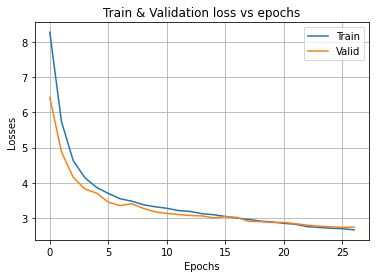

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 1 (Seq=3)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[10]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 7.088504492680736 valid loss: 5.117729753737459 test loss: 6.362756392896612
epoch: 1 train loss: 4.751027265629416 valid loss: 4.308509362663862 test loss: 5.383176772262048
epoch: 2 train loss: 4.199503200231396 valid loss: 3.9686413672850547 test loss: 4.777589011431022
epoch: 3 train loss: 3.910100904461479 valid loss: 3.7017967358572874 test loss: 4.496261011262313
epoch: 4 train loss: 3.705942155769912 valid loss: 3.5280643708700197 test loss: 4.282618408401107
epoch: 5 train loss: 3.5520542350720845 valid loss: 3.409981724198798 test loss: 4.108561200055253
epoch: 6 train loss: 3.447049885495627 valid loss: 3.320854110633751 test loss: 4.016886963904245
epoch: 7 train loss: 3.3429008721595137 valid loss: 3.2695464054815115 test loss: 3.909724002148678
epoch: 8 train loss: 3.275163204682966 valid loss: 3.1887501359801282 test loss: 3.8456226822356245
epoch: 9 train loss: 3.224559351831811 valid loss: 3.154497150151368 test loss: 3.825136112647399
epoch: 10 tr

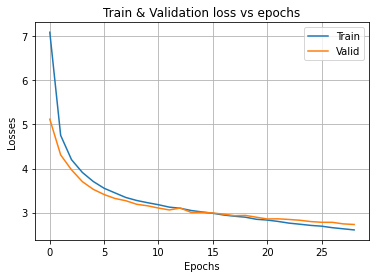

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Overcast - ConvGRU

## Return all layers = yes / convGRU_layers = 1 / fc_layers = 1

In [ ]:
seq_len = 2
num_epochs = 60
learning_rate = 1e-5
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU2(conv_layers=0, convGRU_layers = 1, fc_layers = 1).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 2 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 3.7495163143526122 valid loss: 3.469721381859742 test loss: 2.8654323839672666
epoch: 1 train loss: 3.1883835698571485 valid loss: 3.2143873090051596 test loss: 3.0501374385768822
epoch: 2 train loss: 3.020411850697801 valid loss: 3.071348822475545 test loss: 2.785113536775704
epoch: 3 train loss: 2.866426429797187 valid loss: 2.942482717502649 test loss: 2.923935198258732
epoch: 4 train loss: 2.7631044841609977 valid loss: 2.8271901989050443 test loss: 2.6795961489503544
epoch: 5 train loss: 2.6688843515996252 valid loss: 2.737446673086522 test loss: 2.6160744590408402
epoch: 6 train loss: 2.5606907648524833 valid loss: 2.6554409120660663 test loss: 2.552834658367328
epoch: 7 train loss: 2.4801642508873125 valid loss: 2.574020169457773 test loss: 2.499430818441195
epoch: 8 train loss: 2.3914295585720144 valid loss: 2.498373879828834 test loss: 2.4249655322745225
epoch: 9 train loss: 2.3016464707002564 valid loss: 2.412232960499246 test loss: 2.441700973705461
epoc

## Return all layers = yes / convGRU_layers = 1 / fc_layers = 0

In [ ]:
seq_len = 2
num_epochs = 80
learning_rate = 1e-5
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU2(conv_layers=0, convGRU_layers = 1, fc_layers = 0).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 2 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 4.03542603021995 valid loss: 3.418775528605513 test loss: 3.543848577520339
epoch: 1 train loss: 3.4547237308675425 valid loss: 3.2425143778698873 test loss: 3.0739104876901204
epoch: 2 train loss: 3.3772568131411815 valid loss: 3.1957517809235374 test loss: 3.010974157786992
epoch: 3 train loss: 3.3240652347521884 valid loss: 3.1502288191400485 test loss: 3.0099034048220292
epoch: 4 train loss: 3.2681243751438243 valid loss: 3.1017897022229812 test loss: 2.9932927602241697
epoch: 5 train loss: 3.2082332986165505 valid loss: 3.0446586700373968 test loss: 2.85355034105083
epoch: 6 train loss: 3.146377355861363 valid loss: 2.982980687452224 test loss: 2.850064229793684
epoch: 7 train loss: 3.078806718832826 valid loss: 2.9311792554212692 test loss: 2.889472930331724
epoch: 8 train loss: 2.9999329810105526 valid loss: 2.876768332753731 test loss: 2.873159562885748
epoch: 9 train loss: 2.9262175413237514 valid loss: 2.8033837051891948 test loss: 2.782485669983287
epoch

## Return all layers = yes / convGRU_layers = 1 / fc_layers = 2

In [ ]:
seq_len = 2
num_epochs = 80
learning_rate = 1e-5
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU2(conv_layers=0, convGRU_layers = 1, fc_layers = 2).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 2 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 3.995580459819037 valid loss: 3.421093680421851 test loss: 2.8697243036891957
epoch: 1 train loss: 3.459312791556853 valid loss: 3.321736515615771 test loss: 3.1013462492409576
epoch: 2 train loss: 3.393495761526032 valid loss: 3.2645781137668886 test loss: 3.127641614977431
epoch: 3 train loss: 3.3172745179743077 valid loss: 3.1643362481199153 test loss: 2.9703288418918476
epoch: 4 train loss: 3.2505681870301117 valid loss: 3.079749331922441 test loss: 3.0036490263710207
epoch: 5 train loss: 3.1396342737044582 valid loss: 2.9602836246412223 test loss: 2.821697915092373
epoch: 6 train loss: 3.0389741546062323 valid loss: 2.857351876428629 test loss: 2.7976858483993903
epoch: 7 train loss: 2.928007365663681 valid loss: 2.848396572645617 test loss: 2.988079927998148
epoch: 8 train loss: 2.861252855909728 valid loss: 2.7306090536150593 test loss: 2.869439464838102
epoch: 9 train loss: 2.731381170841681 valid loss: 2.5897406629064257 test loss: 2.709737498416268
epoch:

## Return all layers = yes / convGRU_layers = 3 / fc_layers = 0

In [ ]:
seq_len = 2
num_epochs = 80
learning_rate = 1e-5
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU3(conv_layers=0, convGRU_layers = 3, fc_layers = 0).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 2 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 4.150660361700781 valid loss: 3.6611685248664103 test loss: 3.605304672960435
epoch: 1 train loss: 3.407076881129647 valid loss: 3.499802740175964 test loss: 3.0600612728664767
epoch: 2 train loss: 3.311883590284888 valid loss: 3.449808500431254 test loss: 2.983847937725762
epoch: 3 train loss: 3.2540453314945306 valid loss: 3.386382731644723 test loss: 3.0010973397470355
epoch: 4 train loss: 3.192726810409841 valid loss: 3.3280405773125143 test loss: 2.997666956686932
epoch: 5 train loss: 3.1362922737594197 valid loss: 3.2716459083009912 test loss: 2.9557920274818907
epoch: 6 train loss: 3.074569107285428 valid loss: 3.214498253905677 test loss: 2.933217791499551
epoch: 7 train loss: 3.0160877958913583 valid loss: 3.156174741682965 test loss: 2.9081876110944602
epoch: 8 train loss: 2.9538313619547716 valid loss: 3.0967851798951926 test loss: 2.8663427384393096
epoch: 9 train loss: 2.893258485513463 valid loss: 3.0374730820164206 test loss: 2.7970798782723696
epoch

## Return all layers = yes / convGRU_layers = 3 / fc_layers = 1

In [ ]:
seq_len = 2
num_epochs = 80
learning_rate = 1e-5
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU3(conv_layers=0, convGRU_layers = 3, fc_layers = 1).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 2 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 3.6860547577194476 valid loss: 3.3466388604816943 test loss: 2.8189782162378605
epoch: 1 train loss: 3.111974270533384 valid loss: 2.9979734237308207 test loss: 2.815907897400192
epoch: 2 train loss: 2.8600329183569317 valid loss: 2.80154381580739 test loss: 2.6385617004717257
epoch: 3 train loss: 2.676397521748636 valid loss: 2.635082372011598 test loss: 2.5113032150688728
epoch: 4 train loss: 2.5121979364081546 valid loss: 2.457149799844977 test loss: 2.4857788543049426
epoch: 5 train loss: 2.355314744859466 valid loss: 2.360621107288242 test loss: 2.578769580250586
epoch: 6 train loss: 2.2349662072909084 valid loss: 2.2462836147494842 test loss: 2.2517416168170983
epoch: 7 train loss: 2.1221179943053885 valid loss: 2.12789713804632 test loss: 2.2713524196021204
epoch: 8 train loss: 2.0338896259423542 valid loss: 2.0561838596141797 test loss: 2.264154947905071
epoch: 9 train loss: 1.9376840382748568 valid loss: 1.9936376442041959 test loss: 2.1673938583868946
epo

## Return all layers = yes / convGRU_layers = 3 / fc_layers = 2

In [ ]:
seq_len = 2
num_epochs = 80
learning_rate = 1e-5
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU3(conv_layers=0, convGRU_layers = 3, fc_layers = 2).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 2 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 3.9128741171127284 valid loss: 3.4407679141027594 test loss: 2.989331376647437
epoch: 1 train loss: 3.4118241972336447 valid loss: 3.3350261361014644 test loss: 2.998414737152026
epoch: 2 train loss: 3.3136693617484014 valid loss: 3.2258140943249307 test loss: 2.9687493615440554
epoch: 3 train loss: 3.2072489270545903 valid loss: 3.104954913822695 test loss: 2.867969252731624
epoch: 4 train loss: 3.0850736931296274 valid loss: 2.962020014063835 test loss: 2.8323827700982958
epoch: 5 train loss: 2.9713522467915148 valid loss: 2.826342357559366 test loss: 2.7022221071423553
epoch: 6 train loss: 2.8286035912393763 valid loss: 2.6872546389931484 test loss: 2.621326611446795
epoch: 7 train loss: 2.7244548819464796 valid loss: 2.6985989843510225 test loss: 2.8803721953774417
epoch: 8 train loss: 2.6240838676450857 valid loss: 2.4698094274128444 test loss: 2.428806578827894
epoch: 9 train loss: 2.4926488555633677 valid loss: 2.3486827436650612 test loss: 2.425463541855001

## Return all layers = no / convGRU_layers = 2 / fc_layers = 2

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[4]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 4.464689647491816 valid loss: 3.585965512828041 test loss: 3.9339674820202637
epoch: 1 train loss: 3.5552973900746334 valid loss: 3.23782477900813 test loss: 3.0276196488639155
epoch: 2 train loss: 3.456519310576373 valid loss: 3.194896672654138 test loss: 3.1120751937855484
epoch: 3 train loss: 3.4223975773605146 valid loss: 3.141490345000328 test loss: 3.076564944056006
epoch: 4 train loss: 3.3533615052122787 valid loss: 3.0786366587432994 test loss: 3.0204242426949803
epoch: 5 train loss: 3.289328868523953 valid loss: 3.021277645466195 test loss: 3.0621645756647387
epoch: 6 train loss: 3.210094637143393 valid loss: 2.932726938089362 test loss: 2.948525114156598
epoch: 7 train loss: 3.128461495191887 valid loss: 2.8879950299749257 test loss: 3.0380306031868973
epoch: 8 train loss: 3.036314874118229 valid loss: 2.7692354137448496 test loss: 2.875563001538031
epoch: 9 train loss: 2.9534565556985273 valid loss: 2.667421634280939 test loss: 2.7011845816730418
epoch: 

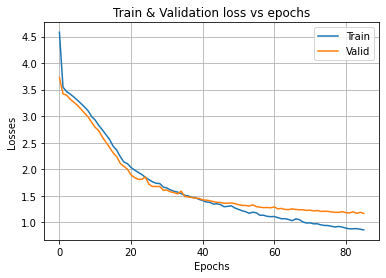

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / conv = 2 / convGRU_layers = 1 / fc_layers = 2 (seq=3)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[5]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c5 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 5.744497856225667 valid loss: 5.2905124491051465 test loss: 3.9320854125962303
epoch: 1 train loss: 4.412393764840913 valid loss: 3.710003372255278 test loss: 2.7930729101701637
epoch: 2 train loss: 3.4692973242135814 valid loss: 3.459502912376287 test loss: 3.1456678811991305
epoch: 3 train loss: 3.39059857269197 valid loss: 3.3742182725635246 test loss: 2.853837502308348
epoch: 4 train loss: 3.3104016090014943 valid loss: 3.295499320470875 test loss: 2.8487335593584397
epoch: 5 train loss: 3.2395488707664026 valid loss: 3.216195409806308 test loss: 2.7822863005614056
epoch: 6 train loss: 3.1543127554729633 valid loss: 3.1220452777508956 test loss: 2.7476668714547383
epoch: 7 train loss: 3.0677947958654768 valid loss: 3.0284195888163565 test loss: 2.6348724405939588
epoch: 8 train loss: 2.9606461146906025 valid loss: 2.9228246543149963 test loss: 2.5836501044276035
epoch: 9 train loss: 2.869137416951848 valid loss: 2.8103967545456214 test loss: 2.55732395969434
ep

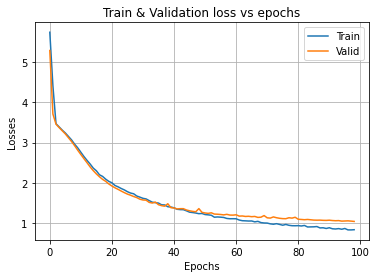

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 0

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[6]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c6 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 5.088033511915265 valid loss: 3.97826710504054 test loss: 2.8549249799310963
epoch: 1 train loss: 3.4785759637452354 valid loss: 3.598161255643699 test loss: 3.3572750003340053
epoch: 2 train loss: 3.4247609516885023 valid loss: 3.5554195165652924 test loss: 3.0658785951199254
epoch: 3 train loss: 3.3854080681378442 valid loss: 3.5412502330975775 test loss: 3.0481420860204196
epoch: 4 train loss: 3.369457730185027 valid loss: 3.52294035648939 test loss: 3.0737671320994187
epoch: 5 train loss: 3.352909071246185 valid loss: 3.5068496433771483 test loss: 3.053518694623347
epoch: 6 train loss: 3.335725615630445 valid loss: 3.4898278566251943 test loss: 3.032926056152559
epoch: 7 train loss: 3.316735315994313 valid loss: 3.4699681697117293 test loss: 3.042652530903001
epoch: 8 train loss: 3.2981138414118396 valid loss: 3.452231703008595 test loss: 3.0019554762642406
epoch: 9 train loss: 3.278137048016758 valid loss: 3.4295783611181117 test loss: 3.013801675795617
epoch:

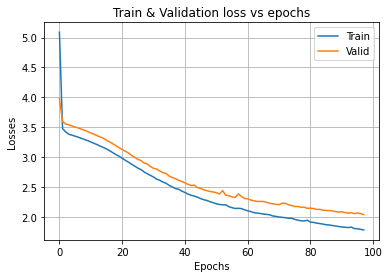

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 1

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[7]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c7 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 3.968422569809372 valid loss: 3.6898218385677795 test loss: 2.814411329617089
epoch: 1 train loss: 3.405558994605591 valid loss: 3.436408917325078 test loss: 2.919615952135545
epoch: 2 train loss: 3.2951427816223635 valid loss: 3.341105171260552 test loss: 2.9032118577616104
epoch: 3 train loss: 3.20555665958353 valid loss: 3.234624598443855 test loss: 2.9513841553633795
epoch: 4 train loss: 3.1239845351622204 valid loss: 3.1433791732815757 test loss: 2.921834179241474
epoch: 5 train loss: 3.044173940259952 valid loss: 3.0587845191321907 test loss: 2.8499313790202443
epoch: 6 train loss: 2.974248767795663 valid loss: 2.977272507915714 test loss: 2.789126293158648
epoch: 7 train loss: 2.9083788848271204 valid loss: 2.8996170295980717 test loss: 2.81818405658547
epoch: 8 train loss: 2.835723822709264 valid loss: 2.827712877235226 test loss: 2.72104310963795
epoch: 9 train loss: 2.769104713210701 valid loss: 2.754972232869532 test loss: 2.691643931265006
epoch: 10 tra

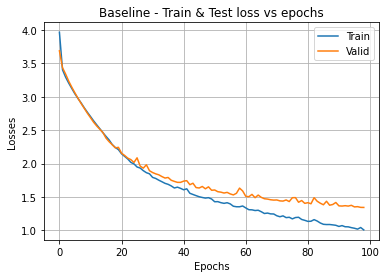

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Baseline - Train & Test loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 0 (seq=3)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[8]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 4.93961950045319 valid loss: 3.633988774882638 test loss: 2.8404427975222033
epoch: 1 train loss: 3.5084640650359646 valid loss: 3.4427631443070665 test loss: 3.3918826410244174
epoch: 2 train loss: 3.4540370150133484 valid loss: 3.3758657628324924 test loss: 3.029715104344906
epoch: 3 train loss: 3.4185581142184116 valid loss: 3.3491863710785075 test loss: 3.073712047960092
epoch: 4 train loss: 3.3909033154656645 valid loss: 3.325333596141333 test loss: 3.054735316748501
epoch: 5 train loss: 3.3631085861994037 valid loss: 3.299798824645846 test loss: 3.0220724668086847
epoch: 6 train loss: 3.33475559627453 valid loss: 3.272429948400457 test loss: 3.0406217553036323
epoch: 7 train loss: 3.3050256965371942 valid loss: 3.2443659292232896 test loss: 2.9897405540679243
epoch: 8 train loss: 3.2733602556920243 valid loss: 3.215605326645111 test loss: 2.9943191669140155
epoch: 9 train loss: 3.242091756519525 valid loss: 3.186932316981508 test loss: 2.957104608152468
epoch

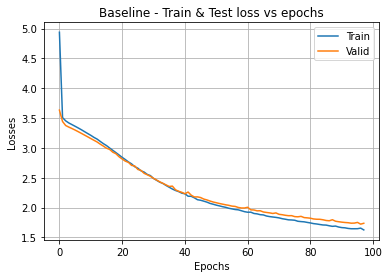

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Baseline - Train & Test loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 2 (seq=3)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[9]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 4.357701743113627 valid loss: 3.8176366096227192 test loss: 4.007745564763295
epoch: 1 train loss: 3.4966160705708518 valid loss: 3.5130651255219636 test loss: 3.0013185005456062
epoch: 2 train loss: 3.3969967971812167 valid loss: 3.460126692341173 test loss: 3.155354352177172
epoch: 3 train loss: 3.360148706019548 valid loss: 3.4121257104194673 test loss: 3.0352764885276358
epoch: 4 train loss: 3.2988424600266253 valid loss: 3.358880465066413 test loss: 3.1055067072767697
epoch: 5 train loss: 3.252132782746175 valid loss: 3.2958949341172548 test loss: 2.94781774257671
epoch: 6 train loss: 3.185134054708893 valid loss: 3.2205255349394664 test loss: 2.9070106195346828
epoch: 7 train loss: 3.106724482927254 valid loss: 3.1309942693758734 test loss: 2.880425384324076
epoch: 8 train loss: 3.012029786986691 valid loss: 3.0382274328041374 test loss: 2.7659606778340935
epoch: 9 train loss: 2.9160002651971957 valid loss: 2.920103445487744 test loss: 2.87181079721608
epoch:

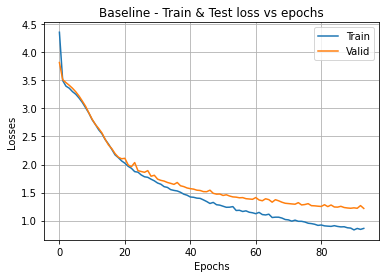

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Baseline - Train & Test loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

## Return all layers = no / convGRU_layers = 2 / fc_layers = 1 (seq=3)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[10]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 3.9645777143595557 valid loss: 3.4592810626525328 test loss: 2.8108819956724895
epoch: 1 train loss: 3.4033590765189587 valid loss: 3.1876699105303885 test loss: 2.9258049890929163
epoch: 2 train loss: 3.24950746453749 valid loss: 3.06541092908832 test loss: 2.8564746287212346
epoch: 3 train loss: 3.1375053028982385 valid loss: 2.928798168125349 test loss: 2.851547333395555
epoch: 4 train loss: 3.011828161784228 valid loss: 2.801757636448378 test loss: 2.8727322883613597
epoch: 5 train loss: 2.886628197943632 valid loss: 2.680851070423869 test loss: 2.6662424180894657
epoch: 6 train loss: 2.7627201114089766 valid loss: 2.5717368285586413 test loss: 2.7786120885207297
epoch: 7 train loss: 2.66058796949758 valid loss: 2.454235749908488 test loss: 2.5423374541377326
epoch: 8 train loss: 2.55157831968574 valid loss: 2.37237312960308 test loss: 2.5887792226755426
epoch: 9 train loss: 2.4599273706143525 valid loss: 2.293261227513426 test loss: 2.4125000450720138
epoch: 1

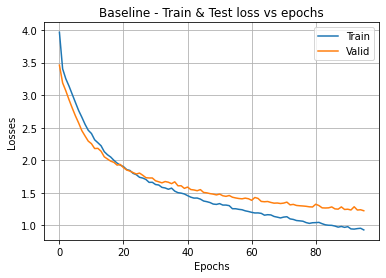

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Baseline - Train & Test loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Final Overall GRU

In [ ]:
overcast_GRU_loss = 1.6817722782882316
cloudy_GRU_loss = 3.5056907896302443
sunny_GRU_loss = 1.2862557947656448

In [ ]:
overall_loss = len(images_test_sunny)*sunny_GRU_loss**2 + len(images_test_cloudy)*cloudy_GRU_loss**2 + len(images_test_overcast)*overcast_GRU_loss**2
overall_loss = overall_loss / (len(images_test_overcast) + len(images_test_sunny) + len(images_test_cloudy))
overall_loss = math.sqrt(overall_loss)
overall_loss

2.221325254752951